In [1]:
from joblib import Parallel, delayed
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from utils import *

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
def append_pairwise_error(df):
    df["pairwise_error"] = 0
    counter = 0
    for algo1 in algorithms:
        for algo2 in algorithms:
            if algo1 != algo2:
                pair_error = ((df[f'{algo1}_pred'] < df[f'{algo2}_pred']) != (df[f'{algo1}_true'] < df[f'{algo2}_true'])).astype(int)
                df["pairwise_error"] += pair_error
                counter += 1
    df["pairwise_error"] /= counter
    return df

In [4]:
algorithms = ['GA', 'PSO', 'DE', 'CMAES', 'ES']
meta_columns = ['problem1', 'problem2', 'instance1', 'instance2', 'alpha', 'dim', 'algorithm_run']
meta_columns_no_run = ['problem1', 'problem2', 'instance1', 'instance2', 'alpha', 'dim']

In [5]:
#dfxgb = pd.read_csv("pred_all_functions_xgboost.csv", index_col=False)pred_all_functions_xgboost_cm_angle
dfxgb = pd.read_csv("pred_all_functions_xgboost_ela_distr.csv", index_col=False)

dfdummy = pd.read_csv("pred_all_functions_dummy.csv", index_col=False)

In [6]:
dfdummy

,problem1,problem2,instance1,instance2,alpha,dim,GA_true,PSO_true,DE_true,CMAES_true,ES_true,GA_pred,PSO_pred,DE_pred,CMAES_pred,ES_pred
0,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.85844,2.938077,3.007457,2.22665,2.969376
1,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.85844,2.938077,3.007457,2.22665,2.969376
2,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.85844,2.938077,3.007457,2.22665,2.969376
3,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.85844,2.938077,3.007457,2.22665,2.969376
4,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.85844,2.938077,3.007457,2.22665,2.969376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474895,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.85844,2.938077,3.007457,2.22665,2.969376
3474896,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.85844,2.938077,3.007457,2.22665,2.969376
3474897,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.85844,2.938077,3.007457,2.22665,2.969376
3474898,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.85844,2.938077,3.007457,2.22665,2.969376


In [7]:
dfrandom = dfdummy.copy()
for a in algorithms:
    dfrandom[f'{a}_pred'] = np.random.rand(len(dfdummy))

In [8]:
dfrandom

,problem1,problem2,instance1,instance2,alpha,dim,GA_true,PSO_true,DE_true,CMAES_true,ES_true,GA_pred,PSO_pred,DE_pred,CMAES_pred,ES_pred
0,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.402119,0.029909,0.595537,0.607854,0.739693
1,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.108863,0.828691,0.795897,0.544705,0.236615
2,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.813436,0.955270,0.418237,0.439600,0.022020
3,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.611211,0.328270,0.346430,0.002077,0.190556
4,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.304381,0.967023,0.016560,0.673636,0.525504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474895,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,0.457900,0.844296,0.468161,0.054873,0.392494
3474896,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,0.298421,0.270006,0.980941,0.744429,0.170850
3474897,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,0.457798,0.934827,0.932623,0.437425,0.466777
3474898,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,0.296625,0.957765,0.424058,0.521861,0.828520


In [9]:
dfxgb = append_pairwise_error(dfxgb)
dfdummy = append_pairwise_error(dfdummy)
dfrandom = append_pairwise_error(dfrandom)

In [10]:
lw=3
xgb_label = 'XGBoost rank'
median_label = 'Mean rank'
random_label = 'Random rank'

y_lims = [-0.05, 0.55]

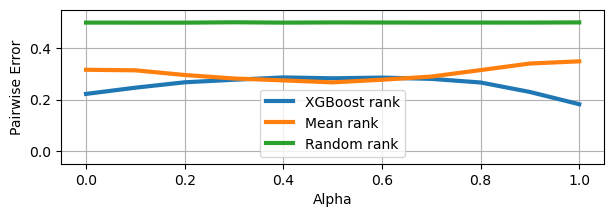

In [11]:
v1 = dfxgb.query('problem1!=problem2').groupby(['alpha']).mean().reset_index()
v2 = dfdummy.query('problem1!=problem2').groupby(['alpha']).mean().reset_index()
v3 = dfrandom.query('problem1!=problem2').groupby(['alpha']).mean().reset_index()

v4 = dfdummy.query('problem1==problem2').groupby(['alpha']).mean().reset_index()
v5 = dfxgb.query('problem1==problem2').groupby(['alpha']).mean().reset_index()

plt.figure(figsize=(7, 2))

# Plot the data
plt.plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
plt.plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
plt.plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)

#plt.plot(v4['alpha'], v4['pairwise_error'], label='Dummy ==')
#plt.plot(v5['alpha'], v5['pairwise_error'], label='XGBoost ==')

plt.grid()
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Pairwise Error')
plt.ylim(y_lims)
plt.savefig(f'figures/accuracy_alphas.pdf', bbox_inches='tight', pad_inches=0)

4 11


Text(0, 0.5, 'Pairwise Error')

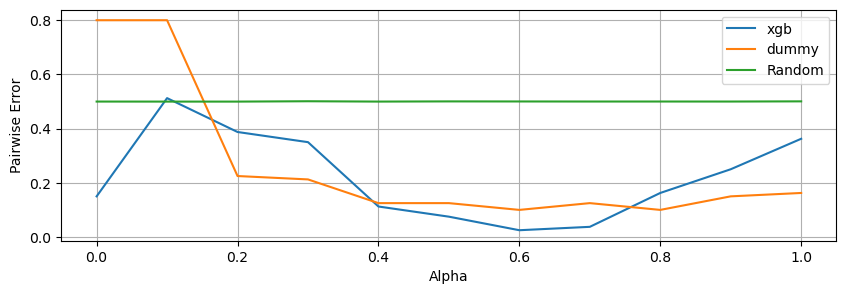

In [12]:
import random

p1 = random.randint(1, 24)
p2 = random.randint(1, 24)
print(p1, p2)
#p1 = 5
#p2 = 7

v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')

plt.figure(figsize=(10, 3))

plt.plot(v1['alpha'], v1['pairwise_error'], label='xgb')
plt.plot(v2['alpha'], v2['pairwise_error'], label='dummy')
plt.plot(v3['alpha'], v3['pairwise_error'], label='Random')

plt.grid()
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Pairwise Error')
#plt.ylim([-0.05, 0.85])

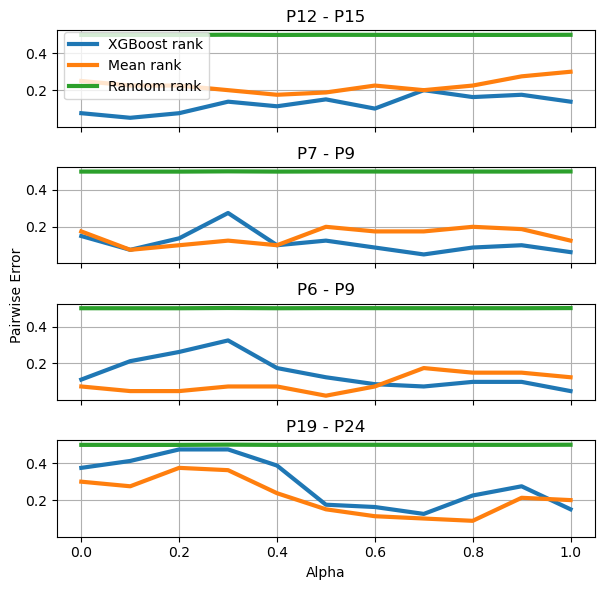

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(6, 6), sharex=True, sharey=True)

p1 = 12
p2 = 15

v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
axes[0].plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
axes[0].plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
axes[0].plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)
axes[0].grid()
axes[0].set_title(f'P{p1} - P{p2}')
#axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.55))

p1 = 19
p2 = 24
v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
axes[3].plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
axes[3].plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
axes[3].plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)
axes[3].grid()
axes[3].set_title(f'P{p1} - P{p2}')

p1 = 7
p2 = 9
v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
axes[1].plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
axes[1].plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
axes[1].plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)
axes[1].grid()
axes[1].set_title(f'P{p1} - P{p2}')

p1 = 6
p2 = 9
v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
axes[2].plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
axes[2].plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
axes[2].plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)
axes[2].grid()
axes[2].set_title(f'P{p1} - P{p2}')

axes[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.05))

axes[-1].set_xlabel("Alpha")
fig.text(0.00, 0.5, "Pairwise Error", va='center', rotation='vertical')

plt.tight_layout()
plt.savefig(f'figures/accuracy_alphas_examples.pdf', bbox_inches='tight', pad_inches=0)